# Проект по оптимизации производственных расходов металлургического комбината

## Содержание
1. [Условие задачи](#1)
2. [План решения задачи](#9)
3. [Описание данных](#3)
4. [Изучение данных](#4)
5. [Подготовка данных](#5)
6. [Выбор модели](#6)
7. [Проверка модели](#7)
8. [Выводы по проекту](#8)

## Условие задачи<a name="1"></a>

Для оптимизации производственных расходов металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет финальную температуру стали.

## План решения задачи <a name="9"></a>

1. **Анализ данных**

    Открыть и изучить файлы с данными. Посмотреть пропуски, дубликаты, аномалии. 
    

2. **Подготовка данных**

    Переименовать столбцы с кириллицы на латиницу. Откорректировать типы данных. Убрать пропуски/аномалии/дубли. Добавить новые признаки. Свести датасеты в одну таблицу. Разбить на валидационную/тестовую выборки. Разбить на признаки/целевой признак. Оценить важность признаков. Проверить на мультиколлинеарность.
    

3. **Построение модели**

    Обучить разные модели, оценить качество с кросс-валидацией. Выбрать лучшую по MAE, проверить на тестовой выборке.
    

4. **Выводы**

    Написать выводы по проекту.

## Описание данных<a name="3"></a>

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Столбец `key` - номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Изучение данных<a name="4"></a>

In [1]:
!pip install catboost -U
!pip install lightgbm -U

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import catboost as cb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sn

Requirement already up-to-date: catboost in c:\users\denis\documents\practicum\lib\site-packages (0.24.1)
Requirement already up-to-date: lightgbm in c:\users\denis\documents\practicum\lib\site-packages (3.0.0)


In [2]:
data_arc = pd.read_csv("final_steel/data_arc.csv") #данные об электродах
data_bulk = pd.read_csv("final_steel/data_bulk.csv") #данные о подаче сыпучих материалов (объём)
data_bulk_time = pd.read_csv("final_steel/data_bulk_time.csv") #данные о подаче сыпучих материалов (время)
data_gas = pd.read_csv("final_steel/data_gas.csv") #данные о продувке сплава газом
data_temp = pd.read_csv("final_steel/data_temp.csv") #результаты измерения температуры
data_wire = pd.read_csv("final_steel/data_wire.csv") #данные о проволочных материалах (объём)
data_wire_time = pd.read_csv("final_steel/data_wire_time.csv") #данные о проволочных материалах (время)
#key - номер партии

In [4]:
data_arc #данные об электродах

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [7]:
# посмотрим на запись с аномальной реактивной мощностью
data_arc[data_arc['Реактивная мощность']==-715.504924]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


In [8]:
# посмотрим на все записи этой партии
data_arc[data_arc['key']==2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


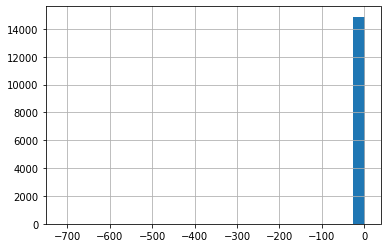

In [9]:
#гистограмма
data_arc['Реактивная мощность'].hist(bins=25)

In [10]:
data_bulk #данные о подаче сыпучих материалов (объём)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [11]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [12]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [13]:
data_bulk_time #данные о подаче сыпучих материалов (время)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [14]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [15]:
data_gas #данные о продувке сплава газом


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [16]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [17]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


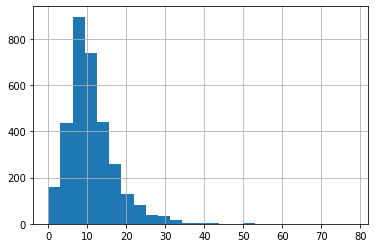

In [18]:
#гистограмма
data_gas['Газ 1'].hist(bins=25)

In [19]:
data_temp #результаты измерения температуры

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [20]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [21]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


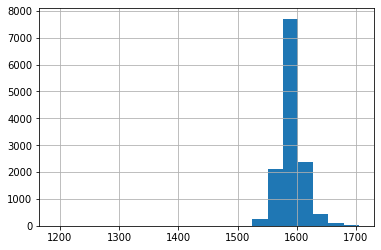

In [22]:
#гистограмма
data_temp['Температура'].hist(bins=20)

In [23]:
data_wire #данные о проволочных материалах (объём)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [25]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [26]:
data_wire_time #данные о проволочных материалах (время)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


### Выводы по анализу данных

1. Необходимые для раюоты библиотеки импортированы.
2. Данные загружены и изучены: 
   - в `data_arc` есть запись с аномальным значением (Реактивная мощность = -715.504924);
   - в `data_bulk` и `data_bulk_time` есть пропуски - в разное время примеси добавляются из разных емкостей;
   - в `data_wire` и `data_wire_time` также пропуски - в разное время проволочные материалы добавляются из разных емкостей;
   - в `data_temp` есть пропуски в столбце с показаниями температуры.

## Подготовка данных<a name="5"></a>

### Работаем с data_temp

In [28]:
# data_temp
#Переименуем "Время замера" в "time", а "Температура" в "temp"
data_temp.columns = ['key','time','temp']
#Уберем записи с пропусками в temp (NaN)
data_temp.dropna(subset = ['temp'],inplace = True)
#time - из object переведем в time 
data_temp['time'] = pd.to_datetime(data_temp['time'], format='%Y-%m-%d %H:%M:%S')
#temp - из float переведем в int
data_temp['temp'] = data_temp['temp'].astype('int64')

In [29]:
#смотрим дубликаты
data_temp.duplicated().sum()

0

In [30]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key     13006 non-null int64
time    13006 non-null datetime64[ns]
temp    13006 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 406.4 KB


In [31]:
data_temp

,key,time,temp
0,1,2019-05-03 11:16:18,1571
1,1,2019-05-03 11:25:53,1604
2,1,2019-05-03 11:29:11,1618
3,1,2019-05-03 11:30:01,1601
4,1,2019-05-03 11:30:39,1613
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569
15883,3238,2019-08-31 23:30:31,1584
15886,3239,2019-09-01 01:31:47,1598
15894,3240,2019-09-01 02:39:01,1617


In [32]:
#посчитаем длительность времени между первым и последним замером температуры
#находим первый и последний замер, а также количество замеров
data_temp_timelag = data_temp.pivot_table(index='key',values='time', aggfunc=[lambda x: len(x.unique()),min,max])
#находим длительность времени
data_temp_timelag['timelag'] = data_temp_timelag['max'] - data_temp_timelag['min']
#переводим в секунды
data_temp_timelag['timelag_sec'] = data_temp_timelag['timelag'].dt.total_seconds()
#переводим в int (из float)
data_temp_timelag['timelag_sec'] = data_temp_timelag['timelag_sec'].astype('int64')
#называем столбцы
data_temp_timelag.columns = ['temp_count','time_first','time_last','temp_timelag','temp_timelag_sec']
#индексуем
data_temp_timelag.reset_index(inplace=True)

In [33]:
data_temp_timelag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 6 columns):
key                 3216 non-null int64
temp_count          3216 non-null int64
time_first          3216 non-null datetime64[ns]
time_last           3216 non-null datetime64[ns]
temp_timelag        3216 non-null timedelta64[ns]
temp_timelag_sec    3216 non-null int64
dtypes: datetime64[ns](2), int64(3), timedelta64[ns](1)
memory usage: 150.9 KB


In [34]:
#выводим с сортировкой по убыванию
data_temp_timelag.sort_values('temp_timelag_sec', ascending=False)

,key,temp_count,time_first,time_last,temp_timelag,temp_timelag_sec
1674,1689,15,2019-07-02 15:28:21,2019-07-02 22:00:38,06:32:17,23537
2091,2108,15,2019-07-23 14:09:40,2019-07-23 19:58:23,05:48:43,20923
1943,1958,9,2019-07-17 21:22:15,2019-07-18 02:38:03,05:15:48,18948
632,641,6,2019-05-26 20:35:10,2019-05-27 01:12:59,04:37:49,16669
629,638,8,2019-05-26 19:29:28,2019-05-26 23:02:37,03:33:09,12789
...,...,...,...,...,...,...
2722,2746,1,2019-08-15 00:53:41,2019-08-15 00:53:41,00:00:00,0
2723,2747,1,2019-08-15 01:43:44,2019-08-15 01:43:44,00:00:00,0
2724,2748,1,2019-08-15 02:35:47,2019-08-15 02:35:47,00:00:00,0
2725,2749,1,2019-08-15 03:22:19,2019-08-15 03:22:19,00:00:00,0


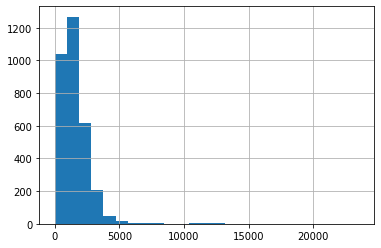

In [35]:
#гистограмма длительности времени между замерами температуры
data_temp_timelag['temp_timelag_sec'].hist(bins=25)

In [36]:
#посмотрим, сколько записей с периодом между замерами температуры, равным 0 
data_temp_timelag.query('temp_timelag_sec == 0').count()
data_temp_timelag[data_temp_timelag['temp_timelag_sec'] == 0].count()

key                 741
temp_count          741
time_first          741
time_last           741
temp_timelag        741
temp_timelag_sec    741
dtype: int64

In [37]:
#удалим такие записи
data_temp_timelag = data_temp_timelag[data_temp_timelag['temp_timelag_sec'] != 0]

In [38]:
#посмотрим, сколько записей лишь с одним замером 
data_temp_timelag[data_temp_timelag['temp_count'] == 1].count()

key                 0
temp_count          0
time_first          0
time_last           0
temp_timelag        0
temp_timelag_sec    0
dtype: int64

In [39]:
data_temp_timelag.reset_index(inplace=True,drop=True)

In [40]:
%%time
#подтянем из data_temp соответствующие первому и последнему времени замера значения температур
data_temp_first = pd.DataFrame()
data_temp_last = pd.DataFrame()
#соберем соответствующие значения temp из data_temp
for i in range(data_temp_timelag.shape[0]):
    temp_key = data_temp_timelag['key'][i]
    time_first = data_temp_timelag['time_first'][i]
    time_last = data_temp_timelag['time_last'][i]
    
    data_temp_first = data_temp_first.append(data_temp.query('(key==@temp_key & time==@time_first)')[['key','temp']], ignore_index=True)
    data_temp_last = data_temp_last.append(data_temp.query('(key==@temp_key & time==@time_last)')[['key','temp']], ignore_index=True)

data_temp_first.columns = ['key','temp_first']   
data_temp_last.columns = ['key','temp_last']   

Wall time: 21.9 s


In [41]:
#добавим к data_temp_timelag
data_temp_timelag = data_temp_timelag.merge(data_temp_first,on='key',how='left')
data_temp_timelag = data_temp_timelag.merge(data_temp_last,on='key',how='left')

In [42]:
data_temp_timelag

,key,temp_count,time_first,time_last,temp_timelag,temp_timelag_sec,temp_first,temp_last
0,1,5,2019-05-03 11:16:18,2019-05-03 11:30:39,00:14:21,861,1571,1613
1,2,6,2019-05-03 11:37:27,2019-05-03 11:59:12,00:21:45,1305,1581,1602
2,3,5,2019-05-03 12:13:17,2019-05-03 12:34:57,00:21:40,1300,1596,1599
3,4,3,2019-05-03 12:52:57,2019-05-03 12:59:25,00:06:28,388,1601,1625
4,5,2,2019-05-03 13:23:19,2019-05-03 13:36:01,00:12:42,762,1576,1602
...,...,...,...,...,...,...,...,...
2470,2495,3,2019-08-06 00:35:45,2019-08-06 00:54:42,00:18:57,1137,1570,1591
2471,2496,4,2019-08-06 01:02:54,2019-08-06 01:29:52,00:26:58,1618,1554,1591
2472,2497,2,2019-08-06 01:41:53,2019-08-06 01:53:50,00:11:57,717,1571,1589
2473,2498,5,2019-08-06 02:03:49,2019-08-06 02:25:31,00:21:42,1302,1591,1594


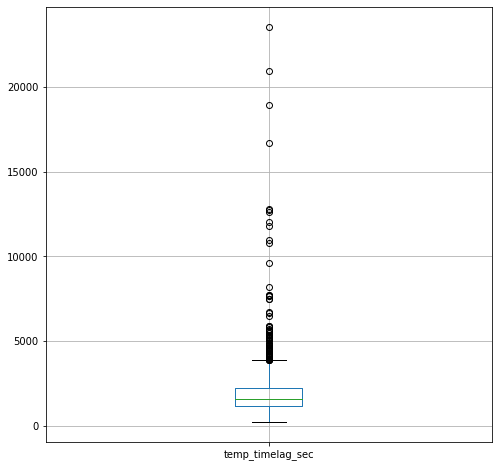

In [43]:
#построим диаграмму размаха для длительности времени между замерами
data_temp_timelag.boxplot('temp_timelag_sec', showfliers=True, figsize=(8,8))

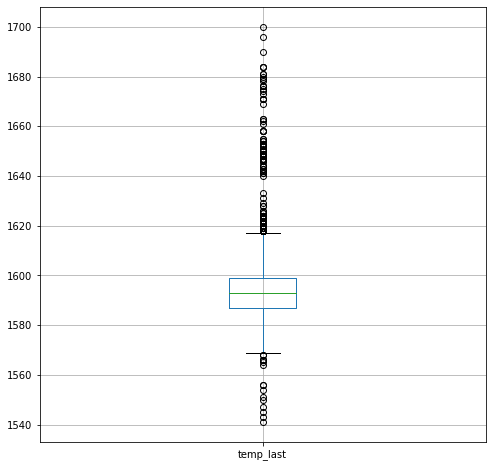

In [44]:
#построим диаграмму размаха для последнего замера
data_temp_timelag.boxplot('temp_last', showfliers=True, figsize=(8,8))

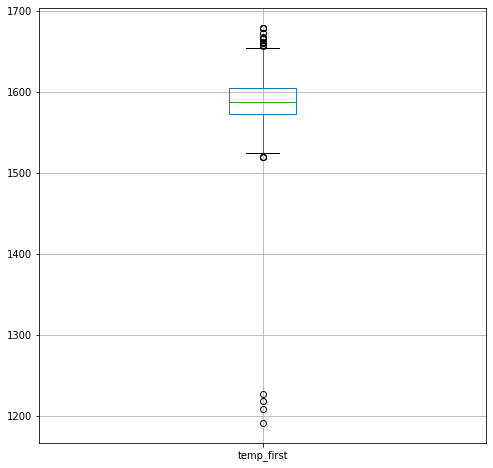

In [45]:
#построим диаграмму размаха для первого замера
data_temp_timelag.boxplot('temp_first', showfliers=True, figsize=(8,8))

In [46]:
# Функция удаления аномалий
def BordersCalc(param,feat):

    res_des = param.describe()
    iqr = res_des[6] - res_des[4]
    k_box = 3
    k_garbage = 1.5
    
    #Считаем границы отсечения
    garbage_bot = res_des[4]-k_garbage*iqr
    if garbage_bot < res_des[3]:
        garbage_bot = res_des[3]

    garbage_top = res_des[6]+k_garbage*iqr
    if garbage_top > res_des[7]:
        garbage_top = res_des[7]
    
    print('Отбрасываем значения',feat,'<',garbage_bot,'и >',garbage_top)
    garbage =[garbage_bot,garbage_top]
    return garbage

In [47]:
#удалим аномальные значения длительности замера
garbage = BordersCalc(data_temp_timelag['temp_timelag_sec'],'temp_timelag_sec')
data_temp_timelag_wo_anomaly = data_temp_timelag[(data_temp_timelag['temp_timelag_sec'] >= garbage[0]) & (data_temp_timelag['temp_timelag_sec'] <= garbage[1])]

data_temp_timelag_wo_anomaly.reset_index(drop=True,inplace=True)

Отбрасываем значения temp_timelag_sec < 234.0 и > 3882.5


In [48]:
data_temp_timelag_wo_anomaly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 8 columns):
key                 2400 non-null int64
temp_count          2400 non-null int64
time_first          2400 non-null datetime64[ns]
time_last           2400 non-null datetime64[ns]
temp_timelag        2400 non-null timedelta64[ns]
temp_timelag_sec    2400 non-null int64
temp_first          2400 non-null int64
temp_last           2400 non-null int64
dtypes: datetime64[ns](2), int64(5), timedelta64[ns](1)
memory usage: 150.1 KB


### Работаем с data_arc

In [49]:
#data_arc
#Переименуем названия столбцов из кириллицы в латиницу
data_arc.columns = ['key','start','finish','real_power','react_power']
#start, finish переведем из object в datetime
data_arc['start'] = pd.to_datetime(data_arc['start'], format='%Y-%m-%d %H:%M:%S')
data_arc['finish'] = pd.to_datetime(data_arc['finish'], format='%Y-%m-%d %H:%M:%S')

In [50]:
#смотрим дубликаты
data_arc.duplicated().sum()

0

In [51]:
#удалим этапы нагревов, которые были до первого замера температуры и после последнего
data_arc_fltr = pd.DataFrame(columns=data_arc.columns)
for i in range(data_temp_timelag_wo_anomaly.shape[0]):
    temp_key = data_temp_timelag_wo_anomaly['key'][i]
    time_first = data_temp_timelag_wo_anomaly['time_first'][i]
    time_last = data_temp_timelag_wo_anomaly['time_last'][i]
    data_arc_fltr = data_arc_fltr.append(data_arc.query('key == @temp_key & start >= @time_first & finish <= @time_last'),ignore_index=True)
print(data_arc_fltr)

       key               start              finish  real_power  react_power
0        1 2019-05-03 11:18:14 2019-05-03 11:24:19    1.659363     1.062669
1        1 2019-05-03 11:26:09 2019-05-03 11:28:37    0.692755     0.414397
2        2 2019-05-03 11:38:50 2019-05-03 11:44:28    1.296415     0.892914
3        2 2019-05-03 11:46:19 2019-05-03 11:48:25    0.490377     0.305281
4        2 2019-05-03 11:49:48 2019-05-03 11:53:18    0.827743     0.516874
...    ...                 ...                 ...         ...          ...
8131  2498 2019-08-06 02:12:24 2019-08-06 02:15:37    0.892648     0.604186
8132  2498 2019-08-06 02:19:43 2019-08-06 02:20:24    0.180213     0.116065
8133  2499 2019-08-06 02:41:09 2019-08-06 02:44:34    0.978407     0.627803
8134  2499 2019-08-06 02:46:03 2019-08-06 02:50:58    1.381264     0.894252
8135  2499 2019-08-06 02:54:31 2019-08-06 02:55:42    0.312893     0.212472

[8136 rows x 5 columns]


In [52]:
#добавим столбец с соотношением потребления активной/реактивной мощности
data_arc_fltr['real_react'] = data_arc_fltr['real_power']/data_arc_fltr['react_power']

In [53]:
# добавим столбец с расчетом полной мощности
data_arc_fltr['full_power'] = np.sqrt(data_arc_fltr['real_power']**2 + data_arc_fltr['react_power']**2)

In [54]:
# добавим столбец с продолжительностью прогрева 
data_arc_fltr['timelag'] = data_arc_fltr['finish'] - data_arc_fltr['start']
#переводим в секунды
data_arc_fltr['timelag_sec'] = data_arc_fltr['timelag'].dt.total_seconds()
#переводим из float в int
data_arc_fltr['timelag_sec'] = data_arc_fltr['timelag_sec'].astype('int64')
#переводим из object в int
data_arc_fltr['key'] = data_arc_fltr['key'].astype('int64')

In [55]:
data_arc_fltr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 9 columns):
key            8136 non-null int64
start          8136 non-null datetime64[ns]
finish         8136 non-null datetime64[ns]
real_power     8136 non-null float64
react_power    8136 non-null float64
real_react     8136 non-null float64
full_power     8136 non-null float64
timelag        8136 non-null timedelta64[ns]
timelag_sec    8136 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(2), timedelta64[ns](1)
memory usage: 572.2 KB


In [56]:
data_arc_fltr

,key,start,finish,real_power,react_power,real_react,full_power,timelag,timelag_sec
0,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.561504,1.970470,00:06:05,365
1,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,1.671717,0.807239,00:02:28,148
2,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.451893,1.574162,00:05:38,338
3,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,1.606312,0.577638,00:02:06,126
4,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,1.601441,0.975867,00:03:30,210
...,...,...,...,...,...,...,...,...,...
8131,2498,2019-08-06 02:12:24,2019-08-06 02:15:37,0.892648,0.604186,1.477439,1.077896,00:03:13,193
8132,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,1.552697,0.214355,00:00:41,41
8133,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,1.558461,1.162504,00:03:25,205
8134,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,1.544602,1.645472,00:04:55,295


In [57]:
#посчитаем сразу все:
#cуммарное время нагрева электродами
#суммарную полную мощность
#количество запусков нагрева электродами
#среднее соотношение потребления активной и реактивной мощности
data_arc_complex = data_arc_fltr.groupby('key').agg({'full_power':['sum'],'timelag_sec':['count','sum'],'real_react':['mean']})


In [58]:
data_arc_complex

full_power timelag_sec      real_react
            sum       count  sum       mean
key                                        
1      2.777708           2  513   1.616610
2      3.127668           3  674   1.553215
3      1.733007           4  375   1.583493
4      1.435385           1  278   1.617762
5      2.254210           2  486   1.508664
...         ...         ...  ...        ...
2495   2.862999           3  516   1.416756
2496   4.569679           5  823   1.515306
2497   2.115554           2  413   1.212267
2498   2.713570           4  494   1.488380
2499   3.186191           3  571   1.525232

[2366 rows x 4 columns]

In [59]:
#переименуем колонки, добавим индекс
data_arc_complex.columns = ['arc_fullpower_sum','arc_count','arc_timelagsec_sum','arc_realreact_mean']
data_arc_complex.reset_index(inplace=True)

In [60]:
data_arc_complex.describe()

,key,arc_fullpower_sum,arc_count,arc_timelagsec_sum,arc_realreact_mean
count,2366.000000,2366.000000,2366.000000,2366.000000,2366.000000
mean,1249.752747,3.360932,3.438715,614.417582,1.373928
std,719.249727,14.747968,1.393524,292.452424,0.151027
min,1.000000,0.114448,1.000000,29.000000,0.558476
25%,629.250000,1.969263,2.000000,402.000000,1.299415
50%,1248.500000,2.921002,3.000000,593.000000,1.389287
75%,1862.750000,3.994040,4.000000,790.000000,1.468981
max,2499.000000,716.607074,9.000000,2160.000000,1.846840


In [61]:
#финальная таблица с обратной сортировкой по суммарному времени нагрева электродами
data_arc_complex.sort_values('arc_fullpower_sum', ascending=False)

,key,arc_fullpower_sum,arc_count,arc_timelagsec_sum,arc_realreact_mean
2000,2116,716.607074,3,311,1.008053
762,813,11.734041,8,2160,0.883343
2139,2260,9.357548,6,1782,1.006057
1915,2019,9.074438,7,1690,1.408561
316,335,9.044387,6,1670,1.242131
...,...,...,...,...,...
732,782,0.192670,1,52,1.420804
986,1048,0.178039,1,45,1.358869
1403,1479,0.175651,1,44,1.322328
543,579,0.149768,1,37,1.595938


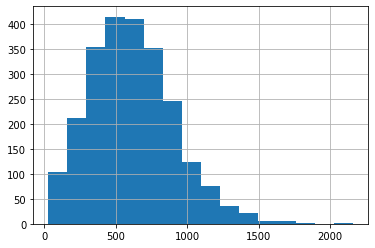

In [62]:
#гистограмма суммарного времени нагрева
data_arc_complex['arc_timelagsec_sum'].hist(bins=16)

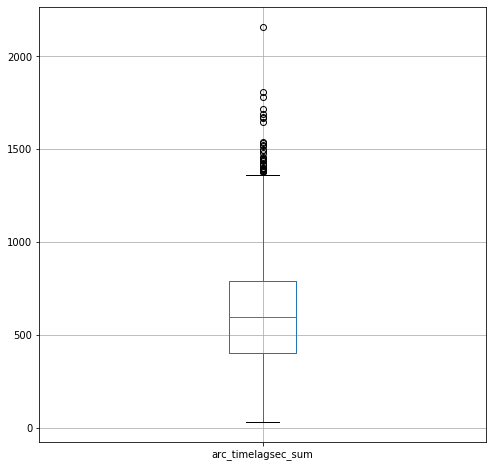

In [63]:
#построим диаграмму размаха для суммарного времени нагрева
data_arc_complex.boxplot('arc_timelagsec_sum', showfliers=True, figsize=(8,8))

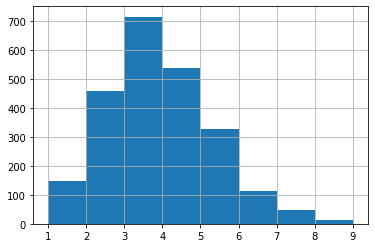

In [64]:
#гистограмма количества нагревов
data_arc_complex['arc_count'].hist(bins=8)

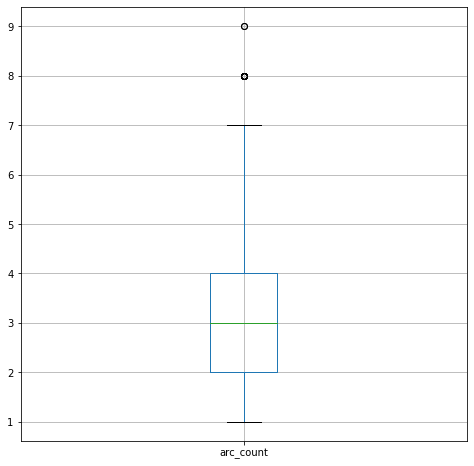

In [65]:
#построим диаграмму размаха для количества нагревов
data_arc_complex.boxplot('arc_count', showfliers=True, figsize=(8,8))

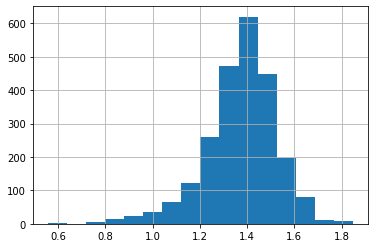

In [66]:
#гистограмма среднего соотношения потребления активной и реактивной мощности
data_arc_complex['arc_realreact_mean'].hist(bins=16)

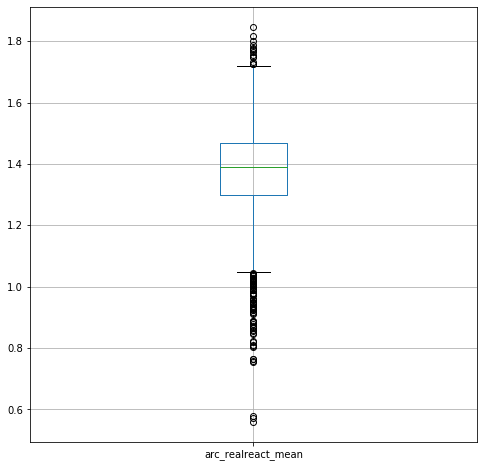

In [67]:
#построим диаграмму размаха для среднего соотношения потребления активной и реактивной мощности
data_arc_complex.boxplot('arc_realreact_mean', showfliers=True, figsize=(8,8))

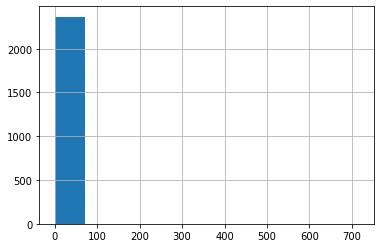

In [68]:
#гистограмма суммы полной мощности
data_arc_complex['arc_fullpower_sum'].hist(bins=10)

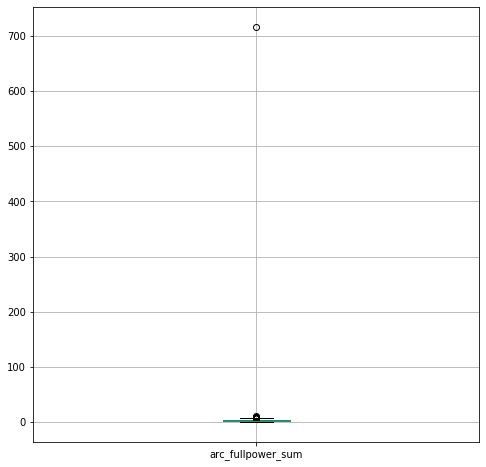

In [69]:
#построим диаграмму размаха для полной мощности
data_arc_complex.boxplot('arc_fullpower_sum', showfliers=True, figsize=(8,8))

In [70]:
#удалим запись с аномальным значением
data_arc_complex = data_arc_complex.loc[data_arc_complex['key'] != 2116]
data_arc_complex.reset_index(drop=True,inplace=True)

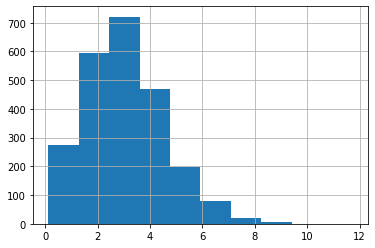

In [71]:
#гистограмма суммы полной мощности после удаления аномальной записи
data_arc_complex['arc_fullpower_sum'].hist(bins=10)

In [72]:
data_arc_complex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 5 columns):
key                   2365 non-null int64
arc_fullpower_sum     2365 non-null float64
arc_count             2365 non-null int64
arc_timelagsec_sum    2365 non-null int64
arc_realreact_mean    2365 non-null float64
dtypes: float64(2), int64(3)
memory usage: 92.5 KB


### Работаем с data_gas

In [73]:
#Переименуем названия столбцов из кириллицы в латиницу
data_gas.columns = ['key','gas']

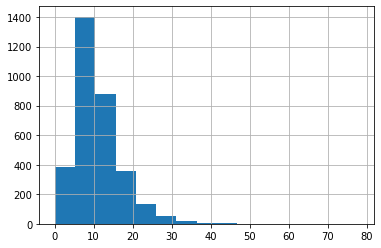

In [74]:
#гистограмма газа
data_gas['gas'].hist(bins=15)

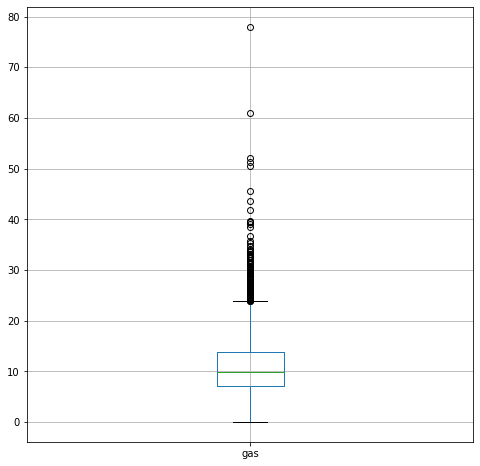

In [75]:
#построим диаграмму размаха
data_gas.boxplot('gas', showfliers=True, figsize=(8,8))

### Работаем с data_bulk и data_bulk_time

In [76]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [77]:
#Переименуем столбцы в data_bulk_time
data_bulk_time.columns = ['key','bulk1','bulk2','bulk3','bulk4','bulk5','bulk6','bulk7','bulk8','bulk9','bulk10','bulk11','bulk12','bulk13','bulk14','bulk15']
#из object переведем в time 
for i in range(1,16):
    bulk = 'bulk'+str(i)
    data_bulk_time[bulk] = pd.to_datetime(data_bulk_time[bulk], format='%Y-%m-%d %H:%M:%S')

In [78]:
#Переименуем столбцы в data_bulk
data_bulk.columns = ['key','bulk1','bulk2','bulk3','bulk4','bulk5','bulk6','bulk7','bulk8','bulk9','bulk10','bulk11','bulk12','bulk13','bulk14','bulk15']

In [79]:
#data_bulk_time

In [80]:
%%time
#удалим этапы добавки примесей, которые были до первого замера температуры и после последнего
del_balk = 0
for i in range(data_temp_timelag_wo_anomaly.shape[0]):
    temp_key = data_temp_timelag_wo_anomaly['key'][i]
    time_first = data_temp_timelag_wo_anomaly['time_first'][i]
    time_last = data_temp_timelag_wo_anomaly['time_last'][i]
    
    for j in range(data_bulk_time.shape[0]):
        if data_bulk_time['key'][j] == temp_key:
            for k in range(1,16):
                bulk = 'bulk'+str(k)
                if data_bulk_time[bulk][j] < time_first or data_bulk_time[bulk][j] > time_last:
                    data_bulk[bulk][j]=np.nan
                    del_balk+=1
                    
print('Удалено этапов добавок примесей:',del_balk) 

Удалено этапов добавок примесей: 1224
Wall time: 2min 48s


In [81]:
#просуммируем примеси
bulks = ['bulk1','bulk2','bulk3','bulk4','bulk5','bulk6','bulk7','bulk8','bulk9','bulk10','bulk11','bulk12','bulk13','bulk14','bulk15']
data_bulk[bulks] = data_bulk[bulks].fillna(0)
data_bulk['bulk_sum'] = data_bulk[bulks].sum(axis=1)

In [82]:
data_bulk.reset_index(drop=True,inplace=True)

In [83]:
data_bulk

,key,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15,bulk_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0


In [84]:
data_bulk_sum = data_bulk[['key','bulk_sum']]

In [85]:
data_bulk_sum.sort_values('bulk_sum', ascending=False)

,key,bulk_sum
303,322,3235.0
1629,1689,1757.0
308,327,1569.0
1933,1999,1563.0
486,513,1498.0
...,...,...
886,922,0.0
882,918,0.0
796,831,0.0
778,812,0.0


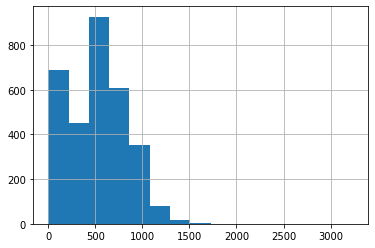

In [86]:
#гистограмма суммарных добавлений примесей
data_bulk_sum['bulk_sum'].hist(bins=15)

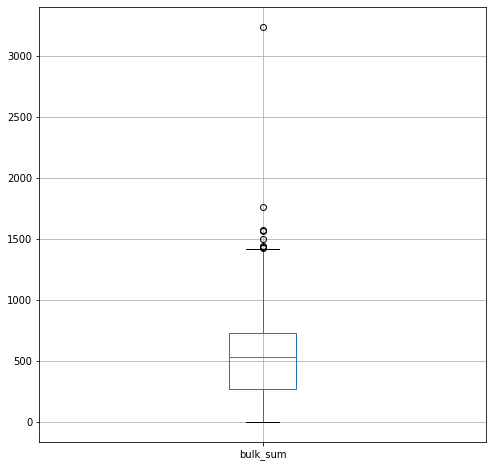

In [87]:
#построим диаграмму размаха суммарных добавлений примесей
data_bulk_sum.boxplot('bulk_sum', showfliers=True, figsize=(8,8))

### Работаем c data_wire и data_wire_time

In [88]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
#Переименуем столбцы data_wire_time
data_wire_time.columns = ['key','wire1','wire2','wire3','wire4','wire5','wire6','wire7','wire8','wire9']
#из object переведем в time 
for i in range(1,10):
    wire = 'wire'+str(i)
    data_wire_time[wire] = pd.to_datetime(data_wire_time[wire], format='%Y-%m-%d %H:%M:%S')

In [90]:
#Переименуем столбцы data_wire
data_wire.columns = ['key','wire1','wire2','wire3','wire4','wire5','wire6','wire7','wire8','wire9']

In [91]:
%%time
#удалим этапы добавки проволоки, которые были до первого замера температуры и после последнего
del_wire = 0
for i in range(data_temp_timelag_wo_anomaly.shape[0]):
    temp_key = data_temp_timelag_wo_anomaly['key'][i]
    time_first = data_temp_timelag_wo_anomaly['time_first'][i]
    time_last = data_temp_timelag_wo_anomaly['time_last'][i]
    
    for j in range(data_wire_time.shape[0]):
        if data_wire_time['key'][j] == temp_key:
            for k in range(1,10):
                wire = 'wire'+str(k)
                if data_wire_time[wire][j] < time_first or data_wire_time[wire][j] > time_last:
                    data_wire[wire][j]=np.nan
                    del_wire+=1
                    
print('Удалено этапов добавления проволоки:',del_wire)

Удалено этапов добавления проволоки: 243
Wall time: 2min 46s


In [92]:
#просуммируем этапы добавки проволоки
wires = ['wire1','wire2','wire3','wire4','wire5','wire6','wire7','wire8','wire9']
data_wire[wires] = data_wire[wires].fillna(0)
data_wire['wire_sum'] = data_wire[wires].sum(axis=1)

In [93]:
data_wire.reset_index(inplace=True,drop=True)

In [94]:
data_wire

,key,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9,wire_sum
0,1,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,5,0.000000,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.114560
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.070400


In [95]:
data_wire_sum=data_wire[['key','wire_sum']]

In [96]:
#гистограмма суммарных добавок проволоки
data_wire_sum['wire_sum'].hist(bins=8)

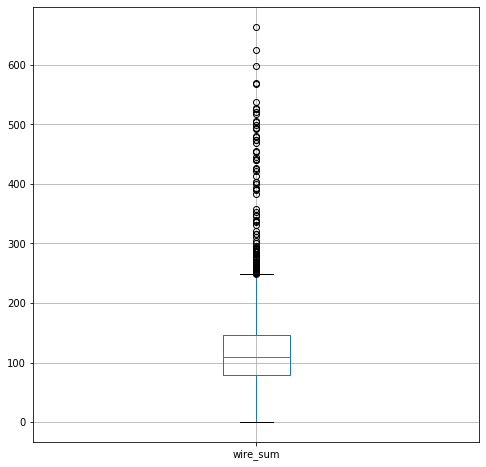

In [97]:
#построим диаграмму размаха суммарных добавок проволоки
data_wire_sum.boxplot('wire_sum', showfliers=True, figsize=(8,8))

In [98]:
#объединим все в один датасет
#data_temp_timelag_wo_anomaly
#data_arc_complex
#data_gas
#data_bulk_sum
#data_wire_sum
data_full = data_temp_timelag_wo_anomaly.merge(data_arc_complex,on='key',how='left')
data_full = data_full.merge(data_gas,on='key',how='left')
data_full = data_full.merge(data_bulk_sum,on='key',how='left')
data_full = data_full.merge(data_wire_sum,on='key',how='left')

In [99]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 0 to 2399
Data columns (total 15 columns):
key                   2400 non-null int64
temp_count            2400 non-null int64
time_first            2400 non-null datetime64[ns]
time_last             2400 non-null datetime64[ns]
temp_timelag          2400 non-null timedelta64[ns]
temp_timelag_sec      2400 non-null int64
temp_first            2400 non-null int64
temp_last             2400 non-null int64
arc_fullpower_sum     2365 non-null float64
arc_count             2365 non-null float64
arc_timelagsec_sum    2365 non-null float64
arc_realreact_mean    2365 non-null float64
gas                   2398 non-null float64
bulk_sum              2332 non-null float64
wire_sum              2297 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(5), timedelta64[ns](1)
memory usage: 300.0 KB


In [101]:
#удалим пропуски
data_full.dropna(inplace=True)
data_full.reset_index(inplace=True,drop=True)

In [102]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 15 columns):
key                   2227 non-null int64
temp_count            2227 non-null int64
time_first            2227 non-null datetime64[ns]
time_last             2227 non-null datetime64[ns]
temp_timelag          2227 non-null timedelta64[ns]
temp_timelag_sec      2227 non-null int64
temp_first            2227 non-null int64
temp_last             2227 non-null int64
arc_fullpower_sum     2227 non-null float64
arc_count             2227 non-null float64
arc_timelagsec_sum    2227 non-null float64
arc_realreact_mean    2227 non-null float64
gas                   2227 non-null float64
bulk_sum              2227 non-null float64
wire_sum              2227 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(5), timedelta64[ns](1)
memory usage: 261.1 KB


In [103]:
data_full

,key,temp_count,time_first,time_last,temp_timelag,temp_timelag_sec,temp_first,temp_last,arc_fullpower_sum,arc_count,arc_timelagsec_sum,arc_realreact_mean,gas,bulk_sum,wire_sum
0,1,5,2019-05-03 11:16:18,2019-05-03 11:30:39,00:14:21,861,1571,1613,2.777708,2.0,513.0,1.616610,29.749986,43.0,0.000000
1,2,6,2019-05-03 11:37:27,2019-05-03 11:59:12,00:21:45,1305,1581,1602,3.127668,3.0,674.0,1.553215,12.555561,582.0,96.052315
2,3,5,2019-05-03 12:13:17,2019-05-03 12:34:57,00:21:40,1300,1596,1599,1.733007,4.0,375.0,1.583493,28.554793,34.0,91.160157
3,4,3,2019-05-03 12:52:57,2019-05-03 12:59:25,00:06:28,388,1601,1625,1.435385,1.0,278.0,1.617762,18.841219,0.0,0.000000
4,5,2,2019-05-03 13:23:19,2019-05-03 13:36:01,00:12:42,762,1576,1602,2.254210,2.0,486.0,1.508664,5.413692,0.0,9.114560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222,2495,3,2019-08-06 00:35:45,2019-08-06 00:54:42,00:18:57,1137,1570,1591,2.862999,3.0,516.0,1.416756,7.125735,111.0,89.150879
2223,2496,4,2019-08-06 01:02:54,2019-08-06 01:29:52,00:26:58,1618,1554,1591,4.569679,5.0,823.0,1.515306,9.412616,796.0,114.179527
2224,2497,2,2019-08-06 01:41:53,2019-08-06 01:53:50,00:11:57,717,1571,1589,2.115554,2.0,413.0,1.212267,6.271699,85.0,103.134723
2225,2498,5,2019-08-06 02:03:49,2019-08-06 02:25:31,00:21:42,1302,1591,1594,2.713570,4.0,494.0,1.488380,14.953657,191.0,118.110717


In [104]:
#разделим на признаки и таргет
target = data_full['temp_last']
features = data_full.drop('temp_last',axis=1)

In [105]:
#проверим наши признаки на мультиколлинеарность
corrMatrix = features.corr()

In [106]:
#посмотрим в табличном виде
corrMatrix

,key,temp_count,temp_timelag_sec,temp_first,arc_fullpower_sum,arc_count,arc_timelagsec_sum,arc_realreact_mean,gas,bulk_sum,wire_sum
key,1.000000,-0.068981,-0.025436,-0.022174,-0.002709,-0.024122,-0.010971,-0.129883,-0.056031,-0.023737,0.013701
temp_count,-0.068981,1.000000,0.559789,0.104872,0.303728,0.449165,0.330322,-0.016616,0.250104,0.225434,0.238581
temp_timelag_sec,-0.025436,0.559789,1.000000,0.214524,0.523347,0.611926,0.559122,-0.009762,0.450493,0.512073,0.345563
temp_first,-0.022174,0.104872,0.214524,1.000000,-0.367032,-0.144948,-0.324303,-0.124489,0.008402,0.065217,0.139930
arc_fullpower_sum,-0.002709,0.303728,0.523347,-0.367032,1.000000,0.739456,0.982850,0.036104,0.303047,0.507264,0.120897
arc_count,-0.024122,0.449165,0.611926,-0.144948,0.739456,1.000000,0.770068,0.041096,0.335942,0.412232,0.222334
arc_timelagsec_sum,-0.010971,0.330322,0.559122,-0.324303,0.982850,0.770068,1.000000,0.037586,0.324791,0.533901,0.143776
arc_realreact_mean,-0.129883,-0.016616,-0.009762,-0.124489,0.036104,0.041096,0.037586,1.000000,0.089906,-0.017699,-0.007327
gas,-0.056031,0.250104,0.450493,0.008402,0.303047,0.335942,0.324791,0.089906,1.000000,0.242057,0.154307
bulk_sum,-0.023737,0.225434,0.512073,0.065217,0.507264,0.412232,0.533901,-0.017699,0.242057,1.000000,0.199181


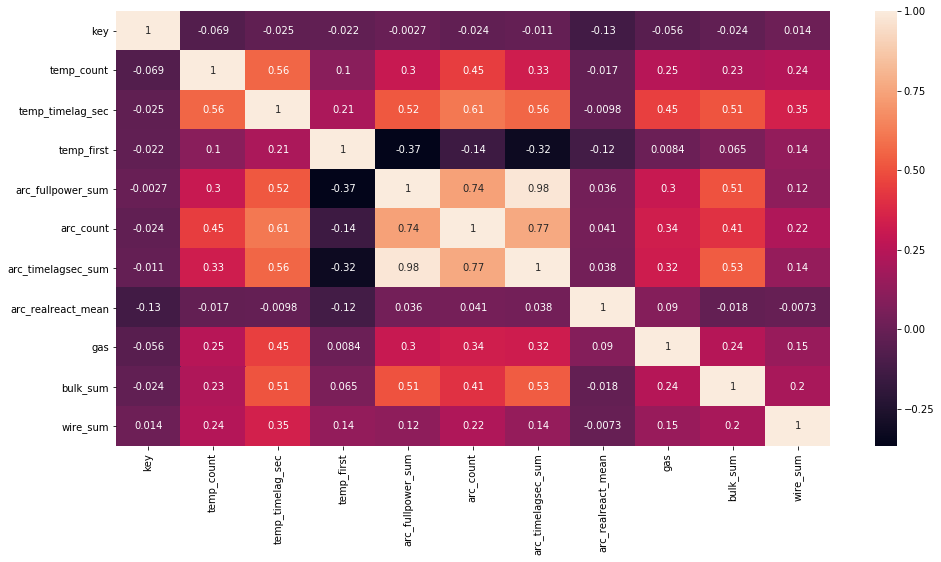

In [107]:
#посмотрим в матричном виде
plt.figure(figsize=(16, 8))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [108]:
#удалим признак 'arc_timelagsec_sum', сильно коррелирующий с 'arc_fullpower_sum'
features.drop(['arc_timelagsec_sum'], axis='columns',inplace=True)

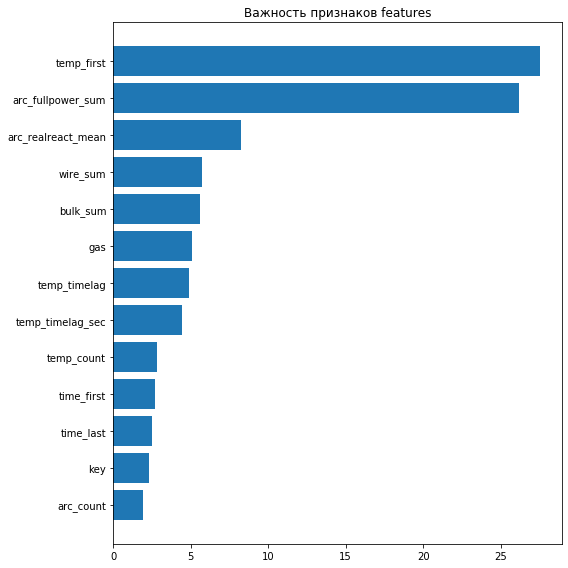

In [109]:
#посмотрим важность признаков
model_cb = cb.CatBoostRegressor(loss_function = 'MAE', verbose=False, random_state=12345)
model_cb.fit(features, target)
feature_importance = model_cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title('Важность признаков features')
fig.tight_layout()
plt.show()

In [110]:
# удалим столбцы, которые не нужны для обучения, уже на основании оценки важности признаков
features.drop(['arc_count','key','time_last','time_first','temp_count','temp_timelag',], axis='columns',inplace=True)

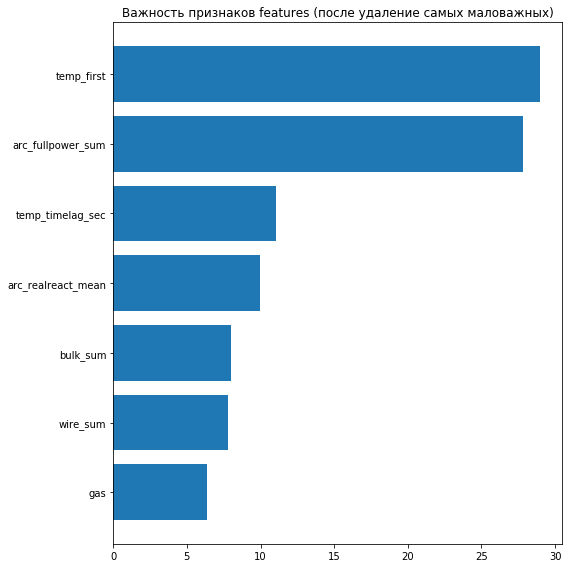

In [111]:
#еще раз посмотрим важность признаков после удаления самых неважных
model_cb = cb.CatBoostRegressor(loss_function = 'MAE', verbose=False, random_state=12345)
model_cb.fit(features, target)
feature_importance = model_cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title('Важность признаков features (после удаления самых маловажных)')
fig.tight_layout()
plt.show()

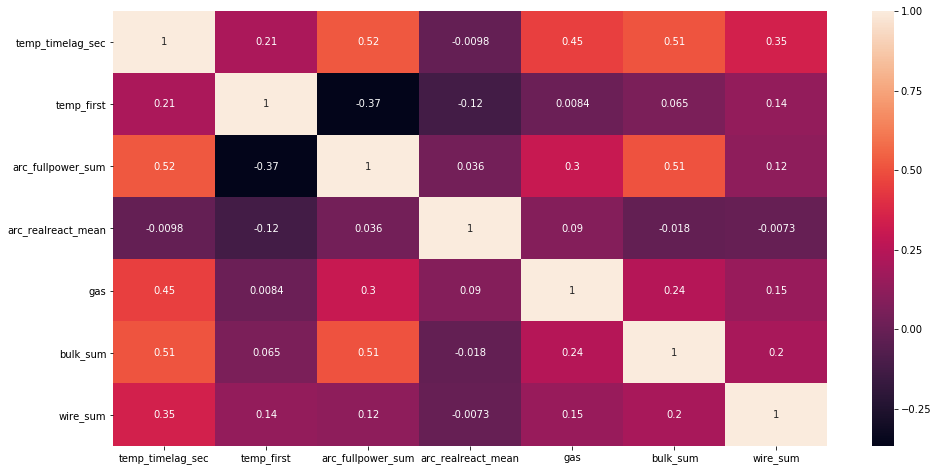

In [112]:
#посмотрим еще раз на корреляционную матрицу, уже с удаленными неважными признаками
corrMatrix = features.corr()
plt.figure(figsize=(16, 8))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [113]:
#разделим на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [114]:
# Масштабируем признаки 
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [115]:
features_train#.head(3)

array([[ 1.46807062,  0.08081753,  0.43859555, ...,  0.64190767,
         0.27561309,  0.09548488],
       [-0.16373936, -1.7996134 ,  1.90113424, ...,  0.18050197,
         1.18702826, -0.66866091],
       [-0.9831764 ,  0.50657547, -1.06858039, ..., -0.44472741,
        -1.15135005, -0.60825506],
       ...,
       [ 0.20076884, -1.5512546 ,  1.81968497, ..., -0.30775525,
         0.31243795,  0.75762756],
       [-0.51553216, -0.30946059, -0.28296509, ...,  0.36545294,
         0.25413193,  0.39528733],
       [-0.82494028, -0.59329922,  0.03002185, ..., -0.18972311,
        -0.08956672, -1.12248639]])

### Выводы по подготовке данных

1. Подготовили данные из файла `data_temp` с замерами температуры:

    - Названия столбцов перевели с кириллицы на латиницу.
    - Изменили типы данных.
    - Нашли первый и последний замеры температуры для каждой пробы.
    - Добавили столбец с длительностью периода между первым и последним замером температуры (в секундах).
    - Удалили записи с нулевой длительностью периода.
    - Удалили записи с аномальными значениями длительности периода между замерами (менее 234 секунд и более 3882.5 секунд).


2. Подготовили данные из файла `data_arc` с замерами мощности:

    - Перевели названия столбцов из кириллицы в латиницу.
    - Удалили для каждой партии записи с этапами нагревов, которые были до первого замера температуры и после последнего.
    - Добавили столбец с соотношением активной/реактивной мощности.
    - Добавили столбец с расчетом полной мощности (корень квадратный из суммы квадратов активной и реактивной мощностей).
    - Сгруппировали по партиям.
    - Добавили столбец с суммарной длительностью нагрева.
    - Добавили столбец с суммарной полной мощностью.
    - Добавили стобец со средним соотношением активной/реактивной мощности.
    - Удалили запись с аномальным значением суммарной мощности (*fullpower_sum* = 716.60, *key* = 2116).


3. Подготовили данные из файла `data_gas` с данными по газу:

    - Перевели названия столбцов из кириллицы в латиницу.


4. Подготовили данные из файлов `data_bulk` и `data_bulk_time` с данными по добавкам примесей:

    - Перевели названия столбцов из кириллицы в латиницу.
    - Поменяли тип столбцов.
    - Для каждой партии удалили этапы добавки примесей, которые были до первого и после последнего замера температуры.
    - Просуммировали добавки примесей для каждой партии.


5. Подготовили данные из файлов `data_wire` и `data_wire_time`  с данными по добавкам проволоки:

    - Перевели названия столбцов из кириллицы в латиницу.
    - Поменяли тип столбцов.
    - Для каждой партии удалили этапы добавки проволоки, которые были до первого и после последнего замера температуры.
    - Просуммировали добавки проволоки для каждой партии.


6. Объединили все данные в одну таблицу (по *key* в температурной таблице), удалили записи с пропусками.


7. Разделили данные на признаки и таргет.


8. **Проверили мультиколлинеарность признаков. Удалили признак суммарной продолжительности нагрева *arc_timelagsec_sum*, сильно коррелирующий с признаком суммарной полной мощности *arc_fullpower_sum*.**


9. **Проверили важность признаков. Неважные признаки удалили.**


10. Разделили данные на тренировочную и тестовую выборки.


11. Масштабировали признаки.   


Не стали вычищать все аномалии в данных, чтобы не получить выборку, слишком далекую от практических производственных данных.
    

## Выбор модели<a name="6"></a>

In [116]:
# оценим качество моделей кросс-валидацией, выберем лучшую
blocks_number = 5 #количество блоков

In [117]:
%%time
# Линейная регрессия
model_lr = LinearRegression()
mae_lr = abs(cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_absolute_error',cv=blocks_number).mean())
print('Среднее MAE модели линейной регрессии =', np.round(mae_lr,2))

Среднее MAE модели линейной регрессии = 6.14
Wall time: 14 ms


In [118]:
%%time
# CatBoost с параметрами по умолчанию:
#iterations = 1000
#learning_rate = 0.03
#depth = 6
#max_leaves = 31

model_cb = cb.CatBoostRegressor(loss_function = 'MAE', verbose=False, random_state=12345)

mae_cb = abs(cross_val_score(model_cb, features_train, target_train, scoring='neg_mean_absolute_error', cv=blocks_number).mean())

print("Среднее MAE модели Catboost =", np.round(mae_cb,2))

Среднее MAE модели Catboost = 5.34
Wall time: 13.3 s


In [119]:
%%time
#LightGBM с параметрами по умолчанию
#num_iterations = 100
#learning_rate = 0.1
#max_depth = -1 #no limit
#num_leaves = 31

params = {'metric':'mae',
          'random_seed':12345,
          'verbose':0,
          'force_col_wise':True,
}
    
d_train = lgb.Dataset(features_train, label=target_train)
    
mae_lb = lgb.cv(params,d_train,nfold=blocks_number)

print("Среднее MAE модели LightGBM =", np.round(np.mean(mae_lb['l1-mean']),2))

Среднее MAE модели LightGBM = 5.64
Wall time: 1.03 s


### Выводы по выбору модели

Сравнили линейную регрессию, CatBoost и LightGBM с помощью кросс-валидации:
- Линейная регрессия: MAE = **6.14**
- CatBoost: MAE = **5.34**
- LightGBM: MAE = **5.64**

Выбрали лучшую по качеству - CatBoost.

Перебор параметров моделей делать не стали, поскольку данный процесс занимает несколько часов, а нужное качество модели достигается и без перебора.

## Проверка модели<a name="7"></a>

In [120]:
%%time
#проверяем модель на тесте
print('Проверяем CatBoost на тестовой выборке')
model_cb = cb.CatBoostRegressor(loss_function = 'MAE', verbose=False, random_state=12345)
model_cb.fit(features_train,target_train)
predicted_test_cb = model_cb.predict(features_test)
mae_test = mean_absolute_error(target_test, predicted_test_cb)
print('MAE на тесте =',np.round(mae_test,2))
print()

Проверяем CatBoost на тестовой выборке
MAE на тесте = 5.84

Wall time: 2.81 s


In [121]:
#проверяем адекватность модели
# медиану сделаем предсказанием
# посчитаем MAE для константной модели
pred_const = pd.Series(target_test.median(), index=target_test.index)
mae_const = mean_absolute_error(target_test, pred_const)
print('Медианная модель. Все целевые признаки  =',pred_const[0])
print('MAE для медианной модели ',np.round(mae_const,2))

Медианная модель. Все целевые признаки  = 1593.0
MAE для медианной модели  8.33


### Выводы по проверке модели

1. Проверили выбранную модель на тестовой выборке, подтвердили ее качество (MAE = **5.84**)
2. Проверили модель на адекватность, сравнив ее с медианной моделью, где все предсказания равны медианному целевому признаку. Наша модель доказала свою адекватность по сравнению с медианной моделью, у которой MAE = 8.33.

## Выводы по проекту <a name="8"></a>

Все задачи проекта выполнены, необходимое качество модели получено:

1. Выполнили анализ данных.

2. Подготовили данные к работе.

3. Построили и сравнили разные модели, выбрали лучшую - CatBoost (MAE = **5.34**)

4. Проверили модель на тестовой выборке, получили MAE = **5.84**. Проверили и подтвердили адекватность модели.

---
---

---